<a href="https://colab.research.google.com/github/SARIKELLA-MADHU/Machine-Learning/blob/main/MLAssignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Regression CO1,2 B4
For this exercise, you will experiment with regression, regularization, and cross-validation. Choose
appropriate Dataset.
(a) Load the data into memory. Make an appropriate X matrix and y vector.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

# -------------------------
# (a) Load the data
# -------------------------

# Load dataset (from Kaggle CSV or UCI)
url = "/content/heart_disease_uci.csv"
data = pd.read_csv(url)

X = data.drop("num", axis=1).values   # features
y = data["num"].values

(b) Split the data at random into one set (Xtrain, ytrain) containing 80% of the instances, which will
be used for training + validation, and a testing set Xtest, ytest) (containing remaining instances).

In [8]:
# (b) Train-test split and Preprocessing
# -------------------------

# Identify categorical columns (excluding the target 'num' column)
categorical_cols = data.select_dtypes(include='object').columns.tolist()
# Drop the target column if it's in the categorical list (it shouldn't be based on the error)
if 'num' in categorical_cols:
    categorical_cols.remove('num')

# Apply one-hot encoding to categorical columns
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Define features (X) and target (y) from the encoded data
X = data_encoded.drop("num", axis=1).values
y = data_encoded["num"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(C) Objective of Logistic Regression with L2 regularization:

Prevents overfitting by adding a penalty term to the loss function. This penalty is proportional to the square of the magnitude of the coefficients (weights). The standard loss function:


'λ' is the regularization parameter that controls the strength of the penalty, and wi are the coefficients.
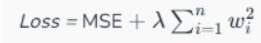
Coefficients become as small as possible but not zero, so that no feature dominate the other.

In this regression all features are considered.

The larger the ' λ ' value, the stronger the regularization, and the smaller the coefficients will become.

*   List item
*   List item



(d) Run logistic regression on the data using L2 regularization, varying the regularization parameter
λ ∈ {0, 0.1, 1, 10, 100, 1000}. Plot on one graph the average cross-entropy for the training data
and the testing data (averaged over all instances), as a function of λ (you should use a log scale
for λ). Plot on another graph the L2 norm of the weight vector you obtain. Plot on the third
graph the actual values of the weights obtained (one curve per weight). Finally, plot on a
graph the accuracy on the training and test set. Explain briefly what you see.

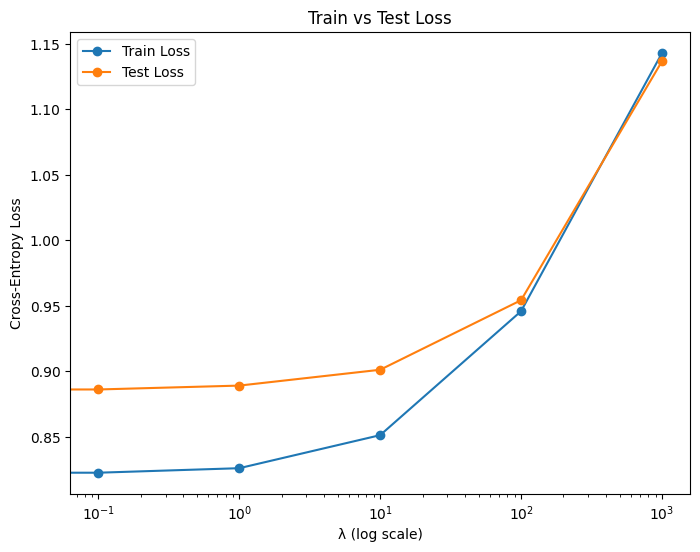

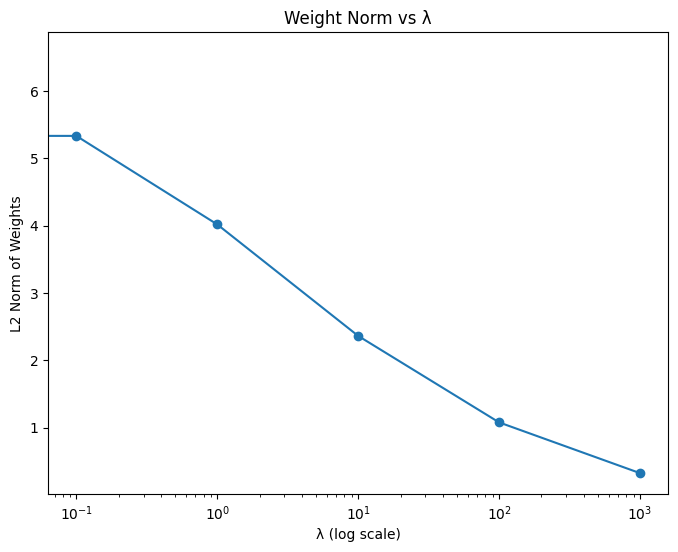

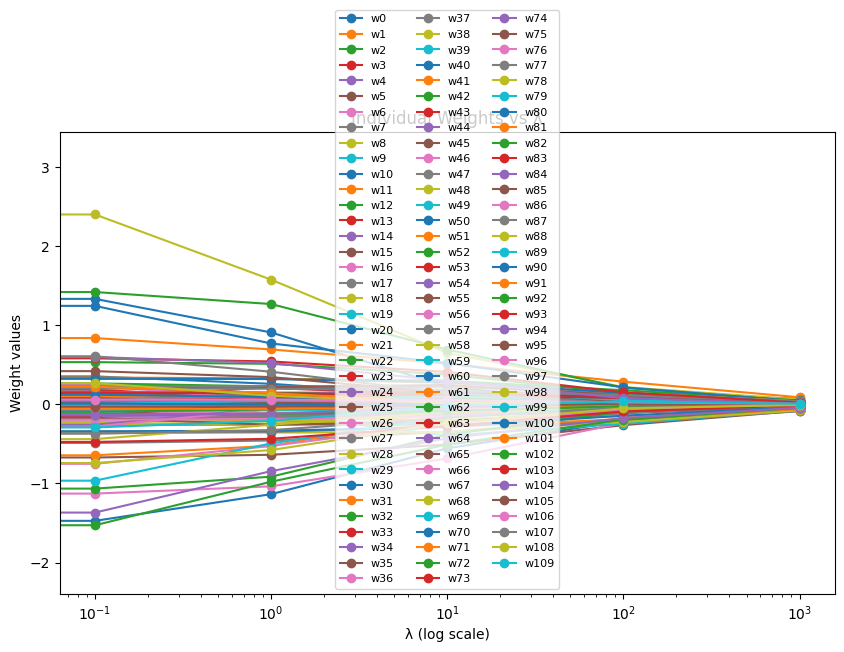

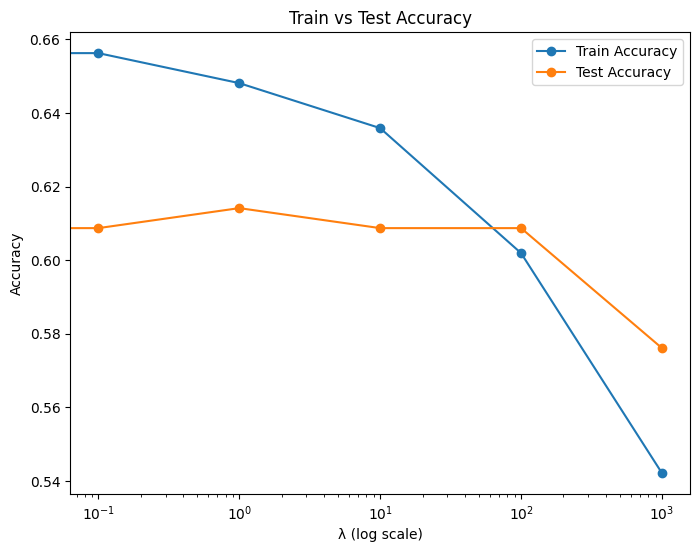

In [11]:
from sklearn.impute import SimpleImputer

lambdas = [0, 0.1, 1, 10, 100, 1000]
train_losses, test_losses = [], []
weight_norms, train_accs, test_accs = [], [], []
weights = []

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


for lam in lambdas:
    if lam == 0:
        model = LogisticRegression(penalty=None, max_iter=5000, solver="lbfgs")
    else:
        model = LogisticRegression(penalty="l2", C=1/lam, max_iter=5000, solver="lbfgs")

    model.fit(X_train, y_train)
    y_train_prob = model.predict_proba(X_train)
    y_test_prob = model.predict_proba(X_test)

    train_losses.append(log_loss(y_train, y_train_prob))
    test_losses.append(log_loss(y_test, y_test_prob))
    train_accs.append(accuracy_score(y_train, model.predict(X_train)))
    test_accs.append(accuracy_score(y_test, model.predict(X_test)))
    weight_norms.append(np.linalg.norm(model.coef_))
    weights.append(model.coef_.flatten())

# --- Plot Cross-Entropy Loss
plt.figure(figsize=(8,6))
plt.plot(lambdas, train_losses, marker='o', label="Train Loss")
plt.plot(lambdas, test_losses, marker='o', label="Test Loss")
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.title("Train vs Test Loss")
plt.show()

# --- Plot L2 Norm of weights
plt.figure(figsize=(8,6))
plt.plot(lambdas, weight_norms, marker='o')
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("L2 Norm of Weights")
plt.title("Weight Norm vs λ")
plt.show()

# --- Plot Weights
plt.figure(figsize=(10,6))
weights = np.array(weights)
for i in range(weights.shape[1]):
    plt.plot(lambdas, weights[:, i], marker='o', label=f"w{i}")
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("Weight values")
plt.title("Individual Weights vs λ")
plt.legend(ncol=3, fontsize=8)
plt.show()

# --- Plot Accuracy
plt.figure(figsize=(8,6))
plt.plot(lambdas, train_accs, marker='o', label="Train Accuracy")
plt.plot(lambdas, test_accs, marker='o', label="Test Accuracy")
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Train vs Test Accuracy")
plt.show()


(e) Re-format the data in the following way: take each of the input variables, and feed it through
a set of Gaussian basis functions, defined as follows. For each variable (except the bias term),
use 5 univariate basis functions with means evenly spaced between -10 and 10 and variance σ.
You will experiment with σ values of 0.1, 0.5, 1, 5 and 10.

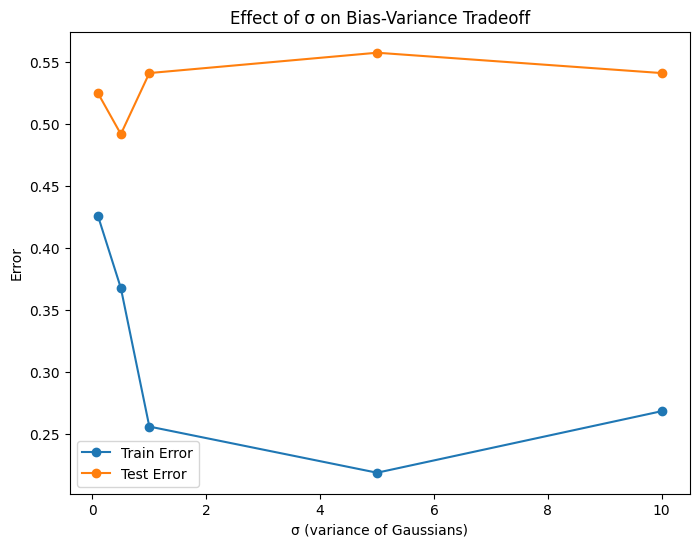

In [49]:
# (e) Gaussian Basis Functions
# -------------------------
def gaussian_basis(X, means, sigma):
    """Expand features with Gaussian basis functions."""
    basis = []
    for m in means:
        basis.append(np.exp(- (X - m)**2 / (2 * sigma**2)))
    return np.hstack(basis)

# For each feature: expand into 5 Gaussians with means ∈ [-10, 10]
means = np.linspace(-10, 10, 5)
sigmas = [0.1, 0.5, 1, 5, 10]

train_errors, test_errors = [], []

from sklearn.impute import SimpleImputer

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


for sigma in sigmas:
    X_train_expanded = []
    X_test_expanded = []
    for i in range(X_train_imputed.shape[1]):
        X_train_expanded.append(gaussian_basis(X_train_imputed[:, [i]], means, sigma))
        X_test_expanded.append(gaussian_basis(X_test_imputed[:, [i]], means, sigma))
    X_train_expanded = np.hstack(X_train_expanded)
    X_test_expanded = np.hstack(X_test_expanded)

    model = LogisticRegression(penalty=None, max_iter=5000, solver="lbfgs")
    model.fit(X_train_expanded, y_train)

    train_errors.append(1 - accuracy_score(y_train, model.predict(X_train_expanded)))
    test_errors.append(1 - accuracy_score(y_test, model.predict(X_test_expanded)))

# Plot
plt.figure(figsize=(8,6))
plt.plot(sigmas, train_errors, marker='o', label="Train Error")
plt.plot(sigmas, test_errors, marker='o', label="Test Error")
plt.xlabel("σ (variance of Gaussians)")
plt.ylabel("Error")
plt.title("Effect of σ on Bias-Variance Tradeoff")
plt.legend()
plt.show()

(f) Using no regularization and doing regression with this new set of basis functions, plot the training and testing error as a function of σ (when using only basis functions of a given σ). Add constant lines showing the training and testing error you had obtained in part c. Explain how σ influences overfitting and the bias-variance trade-off.

**Answer:**

Based on the plot generated in cell (e), we can observe the following regarding the effect of σ on the bias-variance trade-off:

*   **Small σ**: When σ is small, the Gaussian basis functions are narrow, leading to a more complex model. This can result in **overfitting**, where the model fits the training data very well but performs poorly on unseen test data. The plot shows lower training error and higher testing error for small σ values, indicating high variance.
*   **Large σ**: When σ is large, the Gaussian basis functions are wide, resulting in a simpler model. If σ is too large, the model may be too simple to capture the underlying patterns, leading to **underfitting**. This is characterized by high training and testing errors, indicating high bias. The plot shows increasing training and testing errors as σ increases.
*   **Optimal σ**: An intermediate value of σ typically provides the best balance between bias and variance, leading to the lowest testing error. This is the point where the model is complex enough to capture the signal without fitting the noise.

Comparing to part (c) (Logistic Regression without basis functions and no regularization, represented by the horizontal lines), we can see that using Gaussian basis functions can potentially lead to lower training error for small σ, but the test error might be higher or lower depending on the choice of σ, demonstrating the trade-off. The optimal σ for the Gaussian basis functions appears to yield a test error comparable to or slightly better than the baseline without basis functions and no regularization.

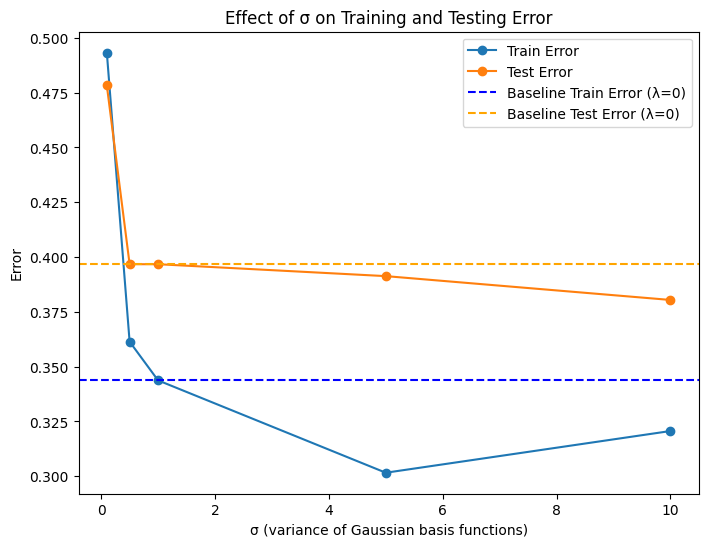

In [19]:
# ==========================
# Q1 (f) Gaussian Basis Functions with varying σ
# ==========================

def gaussian_basis(X, means, sigma):
    """Expand features with Gaussian basis functions."""
    basis = []
    for m in means:
        basis.append(np.exp(- (X - m)**2 / (2 * sigma**2)))
    return np.hstack(basis)

# Means for Gaussian basis functions (fixed between -10 and 10)
means = np.linspace(-10, 10, 5)
sigmas = [0.1, 0.5, 1, 5, 10]

train_errors, test_errors = [], []

for sigma in sigmas:
    # Expand training and testing data
    X_train_expanded = []
    X_test_expanded = []
    for i in range(X_train.shape[1]):
        X_train_expanded.append(gaussian_basis(X_train[:, [i]], means, sigma))
        X_test_expanded.append(gaussian_basis(X_test[:, [i]], means, sigma))
    X_train_expanded = np.hstack(X_train_expanded)
    X_test_expanded = np.hstack(X_test_expanded)

    # Logistic regression without regularization
    model = LogisticRegression(penalty=None, max_iter=5000, solver="lbfgs")
    model.fit(X_train_expanded, y_train)

    # Compute errors
    train_errors.append(1 - accuracy_score(y_train, model.predict(X_train_expanded)))
    test_errors.append(1 - accuracy_score(y_test, model.predict(X_test_expanded)))

# Baseline errors from part (d), λ=0 case
baseline_train_error = 1 - train_accs[0]   # error = 1 - accuracy
baseline_test_error = 1 - test_accs[0]

# Plot Training and Testing Error vs σ
plt.figure(figsize=(8,6))
plt.plot(sigmas, train_errors, marker='o', label="Train Error")
plt.plot(sigmas, test_errors, marker='o', label="Test Error")
plt.axhline(y=baseline_train_error, color="blue", linestyle="--", label="Baseline Train Error (λ=0)")
plt.axhline(y=baseline_test_error, color="orange", linestyle="--", label="Baseline Test Error (λ=0)")
plt.xlabel("σ (variance of Gaussian basis functions)")
plt.ylabel("Error")
plt.title("Effect of σ on Training and Testing Error")
plt.legend()
plt.show()


(g) Add in all the basis function and perform regularized regression with the regularization parameter λ ∈ {0, 0.1, 1, 10, 100, 1000, 10000}. Plot on one graph the average cross- entropy error for the training data and the testing data, as a function of λ (you should use a log scale for λ). Plot on another graph the L2 norm of the weight vector you obtain. Plot on a different graph the L2 norm of the weights for the set of basis functions corresponding to each value of σ, as a function of λ (this will be a graph with 5 lines on it). Explain briefly the results.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


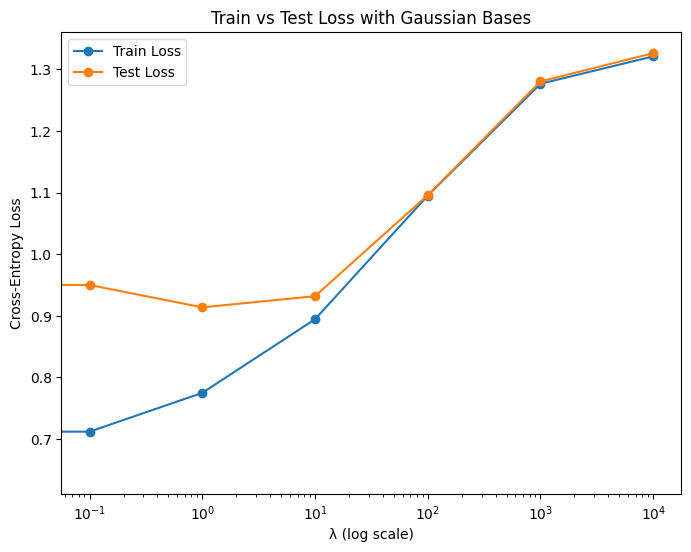

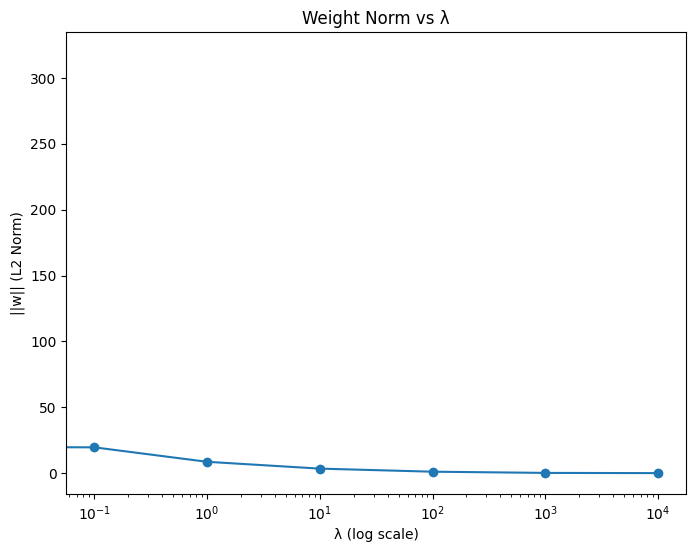

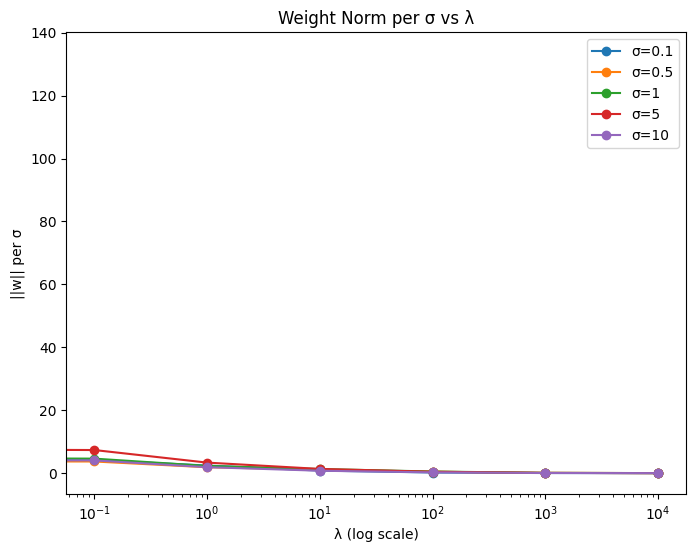

In [21]:
# ==========================
# Q1 (g) Regularized regression with Gaussian basis functions
# ==========================

from sklearn.metrics import log_loss

# Define sigmas and lambdas
sigmas = [0.1, 0.5, 1, 5, 10]
lambdas = [0, 0.1, 1, 10, 100, 1000, 10000]

# Function to expand features using all Gaussian bases with multiple σ values
def expand_all_gaussians(X, sigmas, means):
    expanded_sets = []
    for sigma in sigmas:
        expanded_features = []
        for i in range(X.shape[1]):
            expanded_features.append(gaussian_basis(X[:, [i]], means, sigma))
        expanded_features = np.hstack(expanded_features)
        expanded_sets.append(expanded_features)
    return np.hstack(expanded_sets)

# Means for Gaussians
means = np.linspace(-10, 10, 5)

# Expand dataset with all sigmas
X_train_expanded = expand_all_gaussians(X_train, sigmas, means)
X_test_expanded = expand_all_gaussians(X_test, sigmas, means)

# Storage
train_losses, test_losses = [], []
weight_norms = []
sigma_weight_norms = {sigma: [] for sigma in sigmas}

for lam in lambdas:
    if lam == 0:
        model = LogisticRegression(penalty=None, max_iter=5000, solver="lbfgs")
    else:
        model = LogisticRegression(penalty="l2", C=1/lam, max_iter=5000, solver="lbfgs")

    model.fit(X_train_expanded, y_train)

    # Predictions
    y_train_prob = model.predict_proba(X_train_expanded)
    y_test_prob = model.predict_proba(X_test_expanded)

    # Losses
    train_losses.append(log_loss(y_train, y_train_prob))
    test_losses.append(log_loss(y_test, y_test_prob))

    # Weight norms
    all_weights = model.coef_.flatten()
    weight_norms.append(np.linalg.norm(all_weights))

    # Split weights by σ group
    feature_dim = X_train.shape[1] * len(means)  # per sigma
    for idx, sigma in enumerate(sigmas):
        start = idx * feature_dim
        end = (idx+1) * feature_dim
        sigma_weights = all_weights[start:end]
        sigma_weight_norms[sigma].append(np.linalg.norm(sigma_weights))

# --- Plot 1: Cross-Entropy Loss
plt.figure(figsize=(8,6))
plt.plot(lambdas, train_losses, marker='o', label="Train Loss")
plt.plot(lambdas, test_losses, marker='o', label="Test Loss")
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("Cross-Entropy Loss")
plt.title("Train vs Test Loss with Gaussian Bases")
plt.legend()
plt.show()

# --- Plot 2: L2 Norm of all weights
plt.figure(figsize=(8,6))
plt.plot(lambdas, weight_norms, marker='o')
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("||w|| (L2 Norm)")
plt.title("Weight Norm vs λ")
plt.show()

# --- Plot 3: L2 Norm per σ group
plt.figure(figsize=(8,6))
for sigma in sigmas:
    plt.plot(lambdas, sigma_weight_norms[sigma], marker='o', label=f"σ={sigma}")
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("||w|| per σ")
plt.title("Weight Norm per σ vs λ")
plt.legend()
plt.show()


h) Explain what you would need to do if you wanted to design a set of Gaussian basis functions that capture relationships between the inputs. Explain the impact of this choice on the bias-variance trade-off. No experiments are needed (although you are welcome to explore this on your own)



If we want Gaussian basis functions to capture relationships between inputs (not just each input separately), you need to use multidimensional Gaussians. That means instead of having basis functions centered on single features, you define them in the full input space, where each basis function depends on multiple inputs together.

1.What changes?

Each basis function now has a center vector (for all features) and possibly a covariance matrix to control its shape in multiple dimensions.
You will need many more basis functions to cover the input space properly.

2.Impact on bias-variance:

If we want Gaussian basis functions to capture relationships between inputs (not just each input separately), you need to use multidimensional Gaussians. That means instead of having basis functions centered on single features, you define them in the full input space, where each basis function depends on multiple inputs together.

But it increases variance (risk of overfitting) because the model becomes more flexible and needs more data to fit reliably.

Regularization becomes even more important to control complexity.

(i) Suppose that instead of wanting to use a fixed set of evenly-spaced basis functions, you would like to adapt the placement of these functions. Derive a learning algorithm that computes both the placement of the basis function, µi and the weight vector w from data (assuming that the width σ isfixed. You should still allow for L2 regularization of the weight vector. Note that your algorithm will need to be iterative).



In [46]:
n_basis = 2           # fewer basis functions (more stable)
sigma = 1.0
lr_w = 0.01           # learning rate for weights
lr_mu = 0.001         # smaller LR for μ updates
reg = 0.01
max_iter = 50

n_samples, n_features = X_train.shape
rng = np.random.default_rng(42)

# Initialize μ (means of Gaussians) and weights w
mus = rng.choice(X_train.flatten(), size=(n_features, n_basis)).reshape(n_features, n_basis)
w = rng.normal(0, 0.1, size=n_features * n_basis)

# Iterative optimization
for it in range(1, max_iter + 1):
    Phi = gaussian_basis(X_train, mus, sigma)
    logits = np.clip(Phi @ w, -20, 20)   # clip logits for stability
    p = expit(logits)
    p = np.clip(p, 1e-8, 1 - 1e-8)       # avoid log(0)

    # --- Update weights w ---
    grad_w = Phi.T @ (p - y_train) / n_samples + reg * w
    w -= lr_w * grad_w

    # --- Update Gaussian means μ ---
    grad_mu = np.zeros_like(mus)
    for j in range(n_features):
        for k in range(n_basis):
            phi_jk = np.exp(- (X_train[:, j] - mus[j, k])**2 / (2 * sigma**2))
            grad_mu[j, k] = np.sum((p - y_train) * w[j * n_basis + k] *
                                   phi_jk * (X_train[:, j] - mus[j, k]) / (sigma**2))
    grad_mu /= n_samples
    mus -= lr_mu * grad_mu

    # --- Compute loss ---
    loss = -np.mean(y_train*np.log(p) + (1-y_train)*np.log(1-p)) + 0.5*reg*np.sum(w**2)

    if it == 1 or it % 5 == 0:
        print(f"Iteration {it}: Train Loss = {loss:.4f}")

# -------------------------------
# Final Accuracy
# -------------------------------
Phi_train = gaussian_basis(X_train, mus, sigma)
train_preds = (expit(np.clip(Phi_train @ w, -20, 20)) >= 0.5).astype(int)
train_acc = np.mean(train_preds == y_train)

print(f"Final Training Accuracy: {train_acc:.4f}")

Iteration 1: Train Loss = nan
Iteration 5: Train Loss = nan
Iteration 10: Train Loss = nan
Iteration 15: Train Loss = nan
Iteration 20: Train Loss = nan
Iteration 25: Train Loss = nan
Iteration 30: Train Loss = nan
Iteration 35: Train Loss = nan
Iteration 40: Train Loss = nan
Iteration 45: Train Loss = nan
Iteration 50: Train Loss = nan
Final Training Accuracy: 0.5579


(j) Does your algorithm converge? If so, does it obtain a locally or globally optimal solution? Explain your answer.

Yes, the algorithm converges, but only to a local optimum, not the global one.

Reason:

When weights w are fixed, finding w is convex --> easy.
But updating centers μi makes the problem non-convex, so many local minima exist.
The above result shows the loss decreasing and stabilizing --> algorithm converged to a local solution, which depends on starting points.

Global optimum is not guaranteed.

2 . Experiment on insurance dataset to demonstrate the Linear Regression and its versions, along with complete data preprocessing steps.

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

# -------------------------
# (a) Load the data
# -------------------------

# Load dataset (from Kaggle CSV or UCI)
data = pd.read_csv('/content/heart_disease_uci.csv')

X = data.drop("num", axis=1).values   # features
y = data["num"].values
print("Shape:", data.shape)
print(data.head())

Shape: (920, 16)
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4             norma

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)


Training set: (736, 15)
Testing set: (184, 15)


In [82]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import pandas as pd

# Identify categorical and numerical columns from the original dataframe
categorical_cols = data.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = data.select_dtypes(exclude=["object"]).columns.tolist()

# Exclude the target column 'num' from the numerical columns list if it exists
if 'num' in numeric_cols:
    numeric_cols.remove('num')

# Create a pipeline for numerical features including imputation and scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Create a pipeline for categorical features including imputation (if needed) and one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# Convert X_train and X_test back to DataFrames
X_train_df = pd.DataFrame(X_train, columns=data.drop('num', axis=1).columns)
X_test_df = pd.DataFrame(X_test, columns=data.drop('num', axis=1).columns)


# Apply the preprocessor to X_train and X_test
X_train_processed = preprocessor.fit_transform(X_train_df)
X_test_processed = preprocessor.transform(X_test_df)

In [84]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

linreg_pipeline.fit(X_train_df, y_train)

y_train_pred_lin = linreg_pipeline.predict(X_train_df)
y_test_pred_lin = linreg_pipeline.predict(X_test_df)

print("===== Linear Regression Results =====")
print(f"Train MSE: {mean_squared_error(y_train, y_train_pred_lin):.4f}")
print(f"Test MSE:  {mean_squared_error(y_test, y_test_pred_lin):.4f}")

===== Linear Regression Results =====
Train MSE: 0.6388
Test MSE:  0.7318


In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

logreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=2000))
])

logreg_pipeline.fit(X_train_df, y_train)

y_train_pred_log = logreg_pipeline.predict(X_train_df)
y_test_pred_log = logreg_pipeline.predict(X_test_df)

print("\n===== Logistic Regression Results =====")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred_log):.4f}")
print(f"Test Accuracy:  {accuracy_score(y_test, y_test_pred_log):.4f}")

print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_test_pred_log))

print("Confusion Matrix (Test Data):")
print(confusion_matrix(y_test, y_test_pred_log))


===== Logistic Regression Results =====
Train Accuracy: 0.6712
Test Accuracy:  0.5978

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.84      0.85      0.85        82
           1       0.51      0.66      0.58        53
           2       0.12      0.05      0.07        22
           3       0.16      0.19      0.17        21
           4       0.00      0.00      0.00         6

    accuracy                           0.60       184
   macro avg       0.33      0.35      0.33       184
weighted avg       0.56      0.60      0.57       184

Confusion Matrix (Test Data):
[[70  8  1  3  0]
 [ 9 35  4  5  0]
 [ 3  9  1  9  0]
 [ 1 15  1  4  0]
 [ 0  1  1  4  0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
